In [1]:
from sympy import *
import numpy as np
from sympy.printing import latex
from IPython.display import display, Math

# Define constants and system parameters
quadrotor_mass = 5.3  # Mass of the quadrotor in kilograms
grav_acceleration = 9.81  # Gravitational acceleration in m/s^2

# Define symbols for moments of inertia and geometry
Ix, Iy, Iz, arm_length, height = symbols('Ix Iy Iz arm_length height')

# Define positional and velocity variables
x_w, y_w, z_w = symbols('x_w y_w z_w')
position_world = Matrix([x_w, y_w, z_w])

vx_b, vy_b, vz_b = symbols('vx_b vy_b vz_b')
velocity_body = Matrix([vx_b, vy_b, vz_b])

# Define rotational angles and angular velocities
phi, theta, psi = symbols('\phi \theta \psi')
omega_x, omega_y, omega_z = symbols('omega_x omega_y omega_z')
angular_velocity_body = Matrix([omega_x, omega_y, omega_z])

# Rotation matrices for body orientation relative to the world
R_roll = Matrix([[1, 0, 0],
                 [0, cos(phi), -sin(phi)],
                 [0, sin(phi), cos(phi)]])

R_pitch = Matrix([[cos(theta), 0, sin(theta)],
                  [0, 1, 0],
                  [-sin(theta), 0, cos(theta)]])

R_yaw = Matrix([[cos(psi), -sin(psi), 0],
                [sin(psi), cos(psi), 0],
                [0, 0, 1]])

rotation_world_to_body = R_yaw * R_pitch * R_roll
rotation_body_to_world = rotation_world_to_body.T

# Forces and torques in the body frame
torque_x, torque_y, torque_z, thrust = symbols('torque_x torque_y torque_z thrust')

torque_vector_body = Matrix([torque_x, torque_y, torque_z])
gravity_force_world = Matrix([0, 0, -quadrotor_mass * grav_acceleration])
gravity_force_body = rotation_body_to_world * gravity_force_world

force_body = gravity_force_body + Matrix([0, 0, thrust])

# Inertia matrix in the body frame
inertia_matrix_body = Matrix([[Ix, 0, 0],
                               [0, Iy, 0],
                               [0, 0, Iz]])

# Kinematic equations for position in the world frame
velocity_world = rotation_world_to_body * velocity_body
position_derivative = simplify(velocity_world)

# Kinetic equations for body-fixed velocities
acceleration_body = simplify((1 / quadrotor_mass) * (force_body - angular_velocity_body.cross(quadrotor_mass * velocity_body)))

# Angular velocity derivatives using Euler's equations
angular_velocity_derivative = simplify(inertia_matrix_body.inv() * (torque_vector_body - angular_velocity_body.cross(inertia_matrix_body * angular_velocity_body)))

# Roll, pitch, and yaw rates relative to angular velocity
angular_to_rpy_conversion = Matrix([[1, 0, 0],
                                    [0, cos(phi), sin(phi)],
                                    [0, -sin(phi), cos(phi)]]) * Matrix([[1, 0, 0],
                                                                          [0, cos(theta), sin(theta)],
                                                                          [0, -sin(theta), cos(theta)]])
rpy_rates = simplify(angular_to_rpy_conversion * angular_velocity_body)

# Manually construct the final state derivatives with formatting for readability
state_derivatives = Matrix([
    position_derivative[0],
    position_derivative[1],
    position_derivative[2],
    acceleration_body[0],
    acceleration_body[1],
    acceleration_body[2],
    rpy_rates[0],
    rpy_rates[1],
    rpy_rates[2],
    angular_velocity_derivative[0],
    angular_velocity_derivative[1],
    angular_velocity_derivative[2]
])

# Display each equation in LaTeX format for better readability
print("Reworked system dynamics (displayed in LaTeX):")
for i, row in enumerate(state_derivatives):
    display(Math(f"Equation {i + 1}: {latex(row)}"))

Reworked system dynamics (displayed in LaTeX):


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [63]:
##1
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  #[m/s^2]
mass = 5.3  # [kg]
hover_thrust = (mass * g) / 4  # Thrust required to hover [N] per rotor
dt = 0.01  #[s]
duration = 120  #[s]
times = np.arange(0, duration + dt, dt)  # Time array

# Initialize state variables
position = np.array([0, 0, 1], dtype=float)  # Start at 1m altitude, [x, y, z]
velocity = np.array([0, 0, 0], dtype=float)  # Initial velocity [vx, vy, vz]
roll, pitch, yaw = 0.0, 0.0, 0.0  # Initial Euler angles (radians)
angular_velocity_body = np.array([0, 0, 0])  # Angular velocities [ωx, ωy, ωz]

# Initialize arrays to store results
positions = []  # Store [x, y, z] positions
euler_angles = []  # Store [roll, pitch, yaw]

In [64]:
# Simulation loop
for t in times:
    # Gravity compensation and altitude control
    altitude_error = 1 - position[2]  # Desired altitude = 1m
    vertical_thrust = hover_thrust * 4 + (0.1 * altitude_error)  # Proportional controller

    # Net force (hovering)
    net_force = np.array([0, 0, vertical_thrust - mass * g])
    acceleration = net_force / mass  # Translational acceleration

    # Update position and velocity
    velocity += acceleration * dt
    position += velocity * dt

    # Update Euler angles (no angular velocity applied during hover)
    roll += angular_velocity_body[0] * dt  # (φ)
    pitch += angular_velocity_body[1] * dt  # (θ)
    yaw += angular_velocity_body[2] * dt  # (ψ)

    # Store results
    positions.append(position.copy())
    euler_angles.append([roll, pitch, yaw])

In [65]:
# Convert results to arrays
positions = np.array(positions)
euler_angles = np.array(euler_angles)

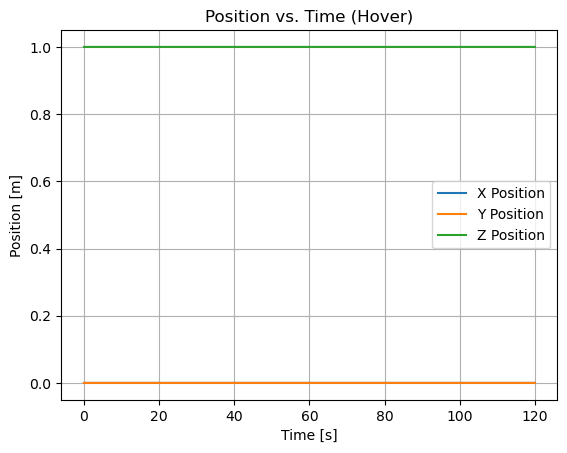

In [66]:
plt.figure()
plt.plot(times, positions[:, 0], label='X Position')
plt.plot(times, positions[:, 1], label='Y Position')
plt.plot(times, positions[:, 2], label='Z Position')
plt.title('Position vs. Time (Hover)')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid()
plt.show()

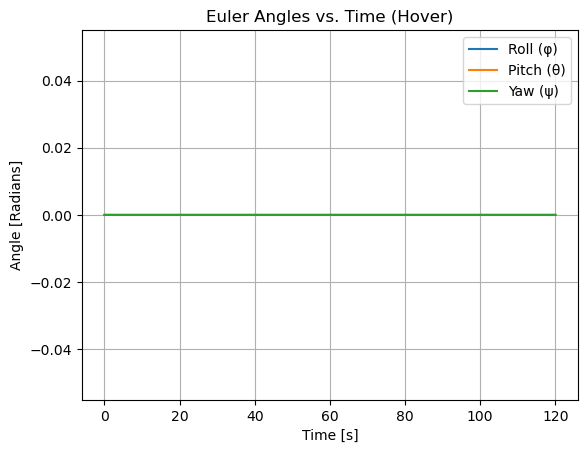

In [67]:
plt.figure()
plt.plot(times, euler_angles[:, 0], label='Roll (φ)')
plt.plot(times, euler_angles[:, 1], label='Pitch (θ)')
plt.plot(times, euler_angles[:, 2], label='Yaw (ψ)')
plt.title('Euler Angles vs. Time (Hover)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [Radians]')
plt.legend()
plt.grid()
plt.show()

In [68]:
#2

# Constants from #1 (shared context)
radius = 2.0  #[m]
speed = 0.5  # [m/s]
angular_velocity = speed / radius  # [rad/s]
dt = 0.01  #[s]
duration = 60  # [s]
times = np.arange(0, duration + dt, dt) 

In [69]:
# Initialize state variables
position = np.array([radius, 0, 1])  
velocity = np.array([0, speed, 0])  
roll, pitch, yaw = 0.0, 0.0, 0.0  

# Initialize arrays to store results
positions = []
euler_angles = []  

In [70]:
# Simulation loop
for t in times:
    # Compute desired position on the circle
    angle = angular_velocity * t  # Angle traveled
    desired_position = np.array([
        radius * np.cos(angle),
        radius * np.sin(angle),
        1  # Maintain altitude at 1m
    ])

    # Compute position error for control
    position_error = desired_position - position

    # Gravity compensation and altitude control
    altitude_error = desired_position[2] - position[2]
    vertical_thrust = hover_thrust * 4 + (0.5 * altitude_error) - (0.1 * velocity[2])  # Improved altitude control

    # Compute centripetal force for circular motion
    centripetal_force = mass * (speed**2 / radius)
    centripetal_force_vector = np.array([
        -centripetal_force * np.cos(angle),
        -centripetal_force * np.sin(angle),
        0  # No vertical component
    ])

    # Net force = centripetal force + gravity compensation
    net_force = centripetal_force_vector + np.array([0, 0, vertical_thrust - mass * g])

    # Compute acceleration, update velocity and position
    acceleration = net_force / mass
    velocity += acceleration * dt
    position += velocity * dt

    # Update yaw (ψ) for circular motion
    yaw += angular_velocity * dt  # Increment yaw based on angular velocity

    # Roll (φ) and Pitch (θ) remain near zero (no intentional tilt)
    roll = 0.0
    pitch = 0.0

    # Store results
    positions.append(position.copy())
    euler_angles.append([roll, pitch, yaw])
    
# Convert results to arrays
positions = np.array(positions)
euler_angles = np.array(euler_angles)

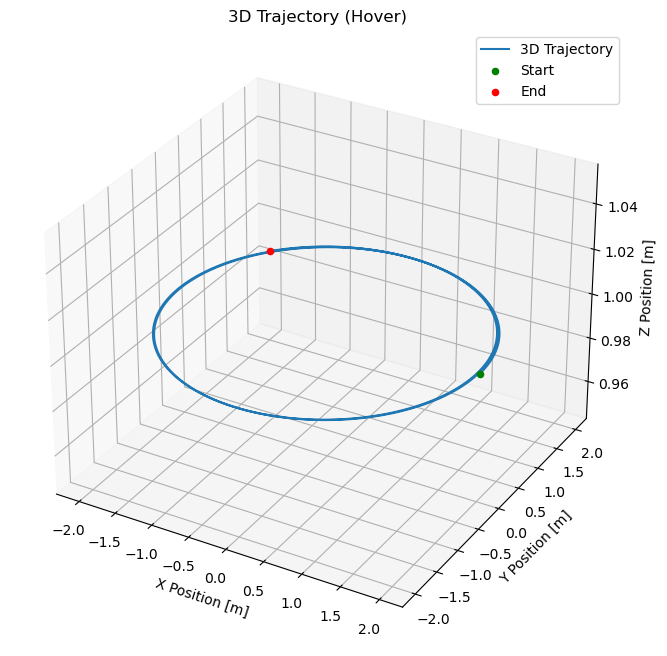

In [85]:
# 3D Trajectory plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='3D Trajectory')
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='green', label='Start')
ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], color='red', label='End')
ax.set_title('3D Trajectory (Hover)')
ax.set_xlabel('X Position [m]')
ax.set_ylabel('Y Position [m]')
ax.set_zlabel('Z Position [m]')
ax.legend()
plt.show()

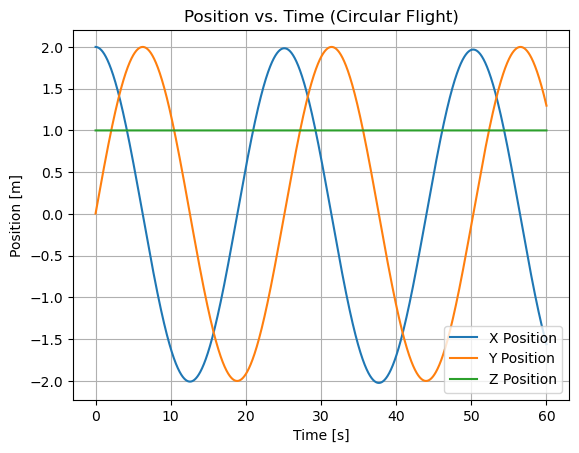

In [71]:
plt.figure()
plt.plot(times, positions[:, 0], label='X Position')
plt.plot(times, positions[:, 1], label='Y Position')
plt.plot(times, positions[:, 2], label='Z Position')
plt.title('Position vs. Time (Circular Flight)')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid()
plt.show()

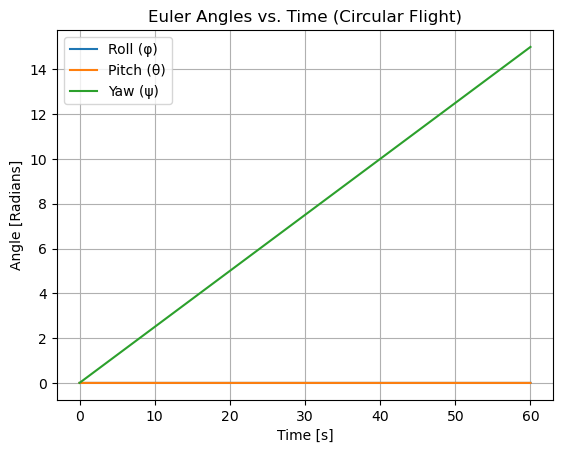

In [72]:
plt.figure()
plt.plot(times, euler_angles[:, 0], label='Roll (φ)')
plt.plot(times, euler_angles[:, 1], label='Pitch (θ)')
plt.plot(times, euler_angles[:, 2], label='Yaw (ψ)')
plt.title('Euler Angles vs. Time (Circular Flight)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [Radians]')
plt.legend()
plt.grid()
plt.show()

In [73]:
##3
# Reuse existing constants
time_vertical_ascent = 1  # time to ascend (s)
time_horizontal_move = 5  # time to move horizontally (s)
hover_time = 2  # time to hover (s)
vertical_speed = 1.0  # ascent speed (m/s)
horizontal_speed = 1.0  # horizontal speed (m/s)
final_descent_speed = 0.01  # target landing speed (m/s)

# Initialize positions, velocities, and angles
x, y, z = [0], [0], [0]  # initial positions
vx, vy, vz = [0], [0], [0]  # initial velocities
yaw, pitch, roll = [0], [0], [0]  # initial angles

In [74]:
# Simulate vertical ascent
for _ in np.arange(0, time_vertical_ascent, dt):
    z.append(z[-1] + vertical_speed * dt)
    vx.append(0)
    vy.append(0)
    vz.append(vertical_speed)
    x.append(x[-1])
    y.append(y[-1])
    yaw.append(yaw[-1])
    pitch.append(0)
    roll.append(0)

In [75]:
# Simulate horizontal movement in a straight line (first segment)
for _ in np.arange(0, time_horizontal_move, dt):
    x.append(x[-1] + horizontal_speed * dt)
    y.append(y[-1])
    z.append(z[-1])
    vx.append(horizontal_speed)
    vy.append(0)
    vz.append(0)
    yaw.append(yaw[-1])
    pitch.append(0)
    roll.append(0)

In [76]:
# Simulate hover
for _ in np.arange(0, hover_time, dt):
    x.append(x[-1])
    y.append(y[-1])
    z.append(z[-1])
    vx.append(0)
    vy.append(0)
    vz.append(0)
    yaw.append(yaw[-1])
    pitch.append(0)
    roll.append(0)

In [77]:
# Simulate yaw 90 degrees to the left
yaw_angle = -90  # degrees
yaw.append(yaw_angle)
pitch.append(0)
roll.append(0)
x.append(x[-1])
y.append(y[-1])
z.append(z[-1])
vx.append(0)
vy.append(0)
vz.append(0)


In [78]:
# Simulate horizontal movement in the second straight line
for _ in np.arange(0, time_horizontal_move, dt):
    x.append(x[-1])
    y.append(y[-1] + horizontal_speed * dt)
    z.append(z[-1])
    vx.append(0)
    vy.append(horizontal_speed)
    vz.append(0)
    yaw.append(yaw[-1])
    pitch.append(0)
    roll.append(0)

In [79]:
# Simulate hover again
for _ in np.arange(0, hover_time, dt):
    x.append(x[-1])
    y.append(y[-1])
    z.append(z[-1])
    vx.append(0)
    vy.append(0)
    vz.append(0)
    yaw.append(yaw[-1])
    pitch.append(0)
    roll.append(0)

In [80]:
# Simulate vertical descent with deceleration
initial_descent_speed = 1.0  # initial descent speed (m/s)
descent_time = 2.0  # time allocated for descent (s)

# Calculate deceleration needed to ensure final speed < 0.01 m/s
deceleration = (initial_descent_speed - final_descent_speed) / descent_time

current_speed = initial_descent_speed
for _ in np.arange(0, descent_time, dt):
    if z[-1] > 0:
        current_speed -= deceleration * dt
        z_new = z[-1] - current_speed * dt
        z_new = max(z_new, 0)  # Ensure it doesn't go below ground
        z.append(z_new)
        vx.append(0)
        vy.append(0)
        vz.append(-current_speed)
        x.append(x[-1])
        y.append(y[-1])
        yaw.append(yaw[-1])
        pitch.append(0)
        roll.append(0)
    else:
        break

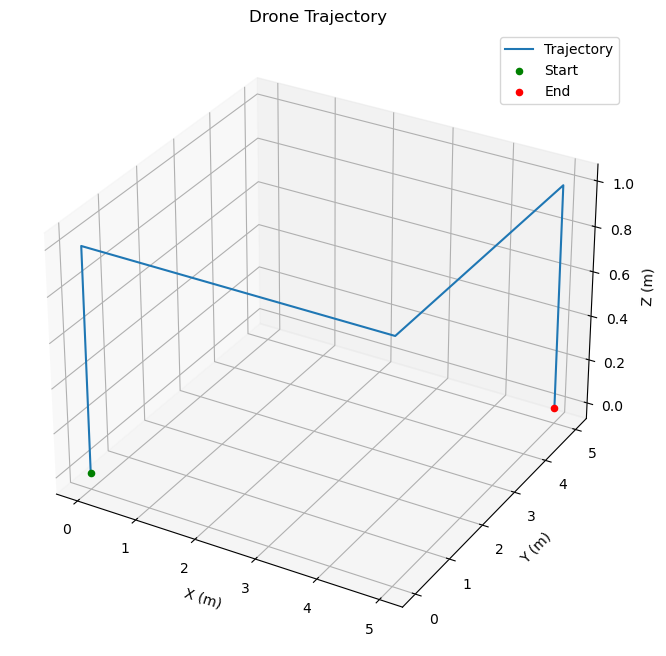

In [81]:
# Time array
time = np.linspace(0, len(x) * dt, len(x))

# Plot 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label="Trajectory")
ax.scatter(x[0], y[0], z[0], c='g', label="Start")
ax.scatter(x[-1], y[-1], z[-1], c='r', label="End")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
plt.title("Drone Trajectory")
plt.legend()

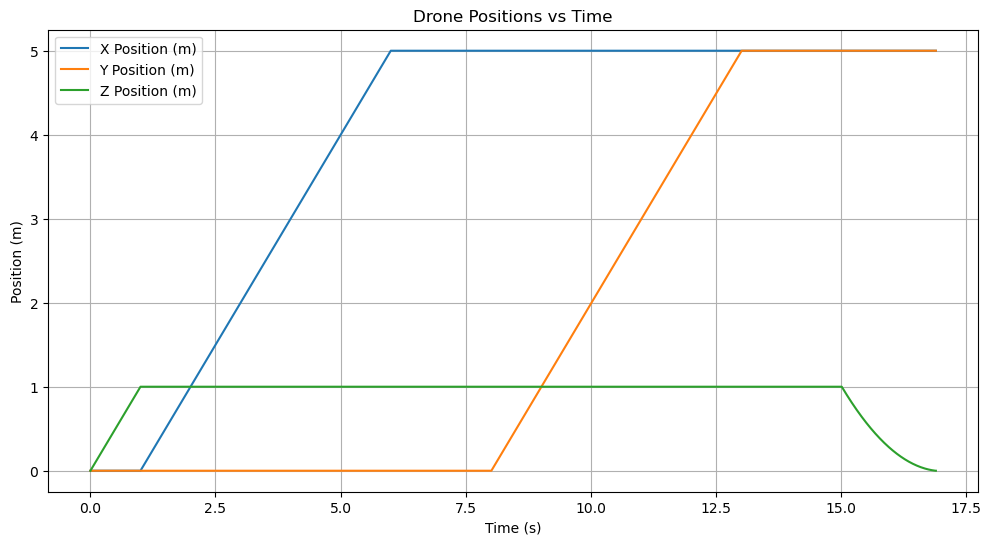

In [82]:
# Plot positions vs. time
plt.figure(figsize=(12, 6))
plt.plot(time, x, label="X Position (m)")
plt.plot(time, y, label="Y Position (m)")
plt.plot(time, z, label="Z Position (m)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Drone Positions vs Time")
plt.legend()
plt.grid()

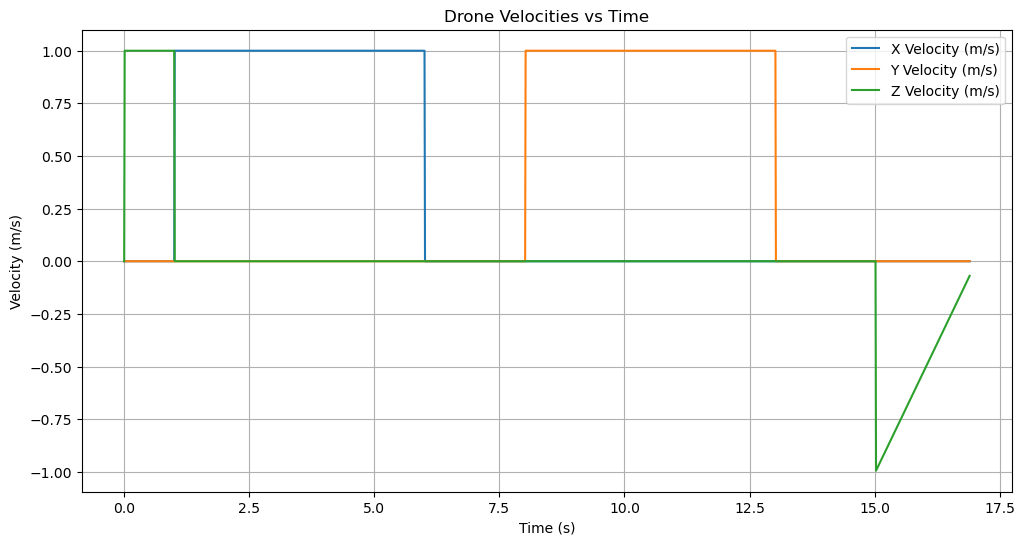

In [83]:
# Plot velocities vs. time
plt.figure(figsize=(12, 6))
plt.plot(time, vx, label="X Velocity (m/s)")
plt.plot(time, vy, label="Y Velocity (m/s)")
plt.plot(time, vz, label="Z Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Drone Velocities vs Time")
plt.legend()
plt.grid()


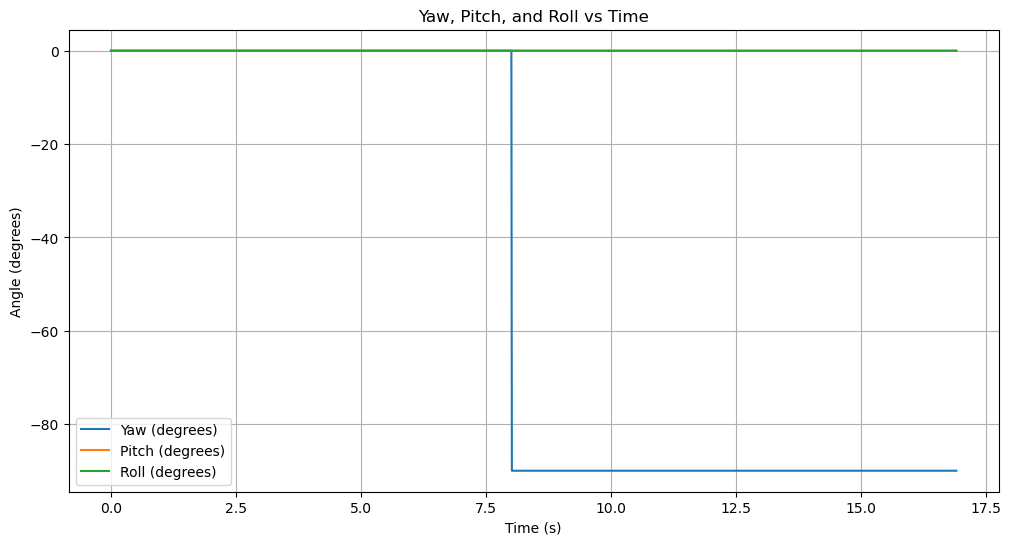

In [84]:
# Plot yaw, pitch, and roll vs. time
plt.figure(figsize=(12, 6))
plt.plot(time, yaw, label="Yaw (degrees)")
plt.plot(time, pitch, label="Pitch (degrees)")
plt.plot(time, roll, label="Roll (degrees)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.title("Yaw, Pitch, and Roll vs Time")
plt.legend()
plt.grid()

plt.show()